# Problem Set 7
## [Submitted by Zhihan Yu]

### Problem 1(a)

In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold

from sklearn.metrics import classification_report, mean_squared_error

wine_data = pd.read_csv("data/strongdrink.txt")
# print(drink_data.head())

# Define x variables
_x = wine_data[['alco', 'malic', 'tot_phen', 'color_int']]

# Define Y variable
_y = wine_data[['cultivar']].values.ravel() # Must use ravel or stupid warning of not inputting correct data type


# Split my data to training and test
X_train, X_test, y_train, y_test = train_test_split(_x, _y, test_size = 0.25, random_state=20)

# Run logistic regression on trianing set
LogReg = LogisticRegression(random_state=20, solver='newton-cg',multi_class='multinomial', max_iter=5000)
result = LogReg.fit(X_train, y_train)

# MSE
y_pred = result.predict(X_test)
MSE_vec_bs = ((y_test != y_pred) ** 2).mean()

# Print results
print('The intercepts for j=1,2: ', result.intercept_[0:2],'\n The coefficients for j=1,2 are\n', result.coef_[0:2])
print(classification_report(y_test, y_pred))
print('Test set MSE: ', MSE_vec_bs)

The intercepts for j=1,2:  [-24.01057113  22.80270738] 
 The coefficients for j=1,2 are
 [[ 1.70036972 -0.26560237  1.22389182  0.02276195]
 [-1.46806485 -0.33305458  0.66401713 -0.92271407]]
              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

   micro avg       0.95      0.95      0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44

Test set MSE:  0.045454545454545456


j=2 has the most observations but j=3 has highest accuracy.

** I think it's also very important for me to note this before I move on: the specified solver method (currently to be newton-cg) makes a significant difference to the resulting MSE. I have tried to use liblinear (the simplest and fastest calculation, but it is not supported for 'a multinomial backend' (according to the error raised). Here on out, I'll specify newton-cg as the solver method. 

*** I have to specify the solver method is because if I do not do so, I get a lot of 'FutureWanings'. Though they do not stop me from writing my homework, they are annoying to see. Plus, doing it the current way will not result in errors in the recent future (when sklearn updates their packages). 

### Problem 1(b)

In [2]:
# Reset x and y
Xvals = _x.values
N_loo = _x.shape[0]
yvals = _y

# Set up leave one out
loo = LeaveOneOut()
loo.get_n_splits(Xvals)
MSE_vec = np.zeros(N_loo)
error = 0

for train_index, test_index in loo.split(Xvals):
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index] 
    LogReg = LogisticRegression(solver='newton-cg', multi_class='auto') # the solver makes a big difference. 
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    error += int((y_test!=y_pred))
    MSE_vec[test_index] = (y_test != y_pred) ** 2
error_rate = error/N_loo
MSE_loo = MSE_vec.mean()

In [3]:
# Print results
print('Error rate: ', error_rate)
print('MSE loocvL: ', MSE_loo)

Error rate:  0.07954545454545454
MSE loocvL:  0.07954545454545454


The error rate is higher than (a). 

### Problem 1(c)

In [4]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4, shuffle=True, random_state=10)
kf.get_n_splits(Xvals)
MSE_vec_kf = np.zeros(4)
error = 0
k_ind = int(0)
for train_index, test_index in kf.split(Xvals):
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = _y[train_index], _y[test_index]
    LogReg = LogisticRegression(solver='newton-cg', multi_class='auto')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    error += (y_test!=y_pred).mean()
    MSE_vec_kf[k_ind] = ((y_test != y_pred) ** 2).mean()
    k_ind += 1
error_rate = error/k_ind
MSE_kf = MSE_vec_kf.mean()
print('The test has the error rate =', error_rate,
      'and estimate MSE loocv =', MSE_kf)


The test has the error rate = 0.09090909090909091 and estimate MSE loocv = 0.09090909090909091


The error rate is higher than (a) and (b). 

### Problem 2(a)


In [5]:
from matplotlib import pyplot as plt
import statsmodels.api as sm
from scipy.interpolate import LSQUnivariateSpline

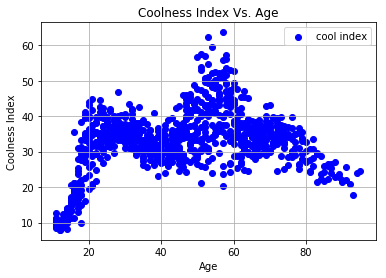

In [6]:
Cool = pd.read_csv('data/CoolIndex.txt', names = ['age','cool index'])
fig,ax = plt.subplots()
ax.scatter(Cool['age'],Cool['cool index'],color = 'b')
ax.set_xlabel('Age')
ax.set_ylabel('Coolness Index')
ax.set_title('Coolness Index Vs. Age')
ax.grid()
ax.legend()
plt.show()

### Problem 2(b)

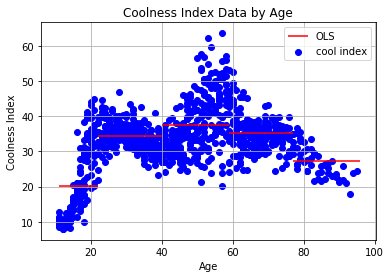

In [7]:
bins = pd.cut(Cool['age'],(11, 22, 40, 59, 77, 96), right=False)
Cool['age range'] = bins
Dummies = pd.get_dummies(Cool['age range'])
Dummies.columns = ['range 1','range 2','range 3','range 4','range 5']
Cool = pd.concat([Cool,Dummies],axis=1)
Up = [11, 22, 40, 59, 77]
Down = [22, 40, 59, 77, 96]

reg = sm.OLS(Cool['cool index'],Cool[['range 1','range 2','range 3','range 4','range 5']])
results = reg.fit()
Coef = np.array(results.params.values)
Cool['predict'] = 0.0
Cool['predict'] = results.predict(Cool[['range 1','range 2','range 3','range 4','range 5']])
fig,ax = plt.subplots()
ax.hlines(Coef,Up,Down,color='r',label = 'OLS')
ax.scatter(Cool['age'],Cool['cool index'],color = 'b')
ax.set_xlabel('Age')
ax.set_ylabel('Coolness Index')
ax.set_title('Coolness Index Data by Age')
ax.grid()
ax.legend()
plt.show()

In [8]:
print('The predicted (stepwise function) coolness index for 73-year-old person is %0.3f' \
      %(results.predict([0,0,0,1,0])[0]))

The predicted (stepwise function) coolness index for 73-year-old person is 35.225


### Problem 2(c)

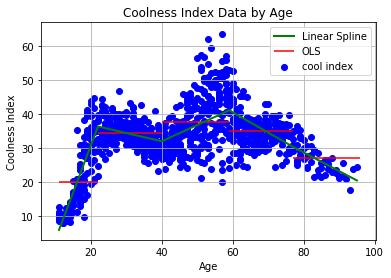

In [9]:
X = np.arange(11,96)
def get_y(x):
    y = np.zeros(x.size)
    for i in range(x.size):
        number = x[i]
        y[i] = Cool['cool index'][Cool['age']==number].mean()
    return y
y = get_y(X)
LSQ = LSQUnivariateSpline(X,y,t=[22,40,59,77],k=1)
fig,ax = plt.subplots()
ax.hlines(Coef,Up,Down,color='r',label = 'OLS')
ax.plot(Cool['age'],LSQ(Cool['age']),color='g',label = 'Linear Spline',lw=2)
ax.scatter(Cool['age'],Cool['cool index'],color = 'b')
ax.set_xlabel('Age')
ax.set_ylabel('Coolness Index')
ax.set_title('Coolness Index Data by Age')
ax.grid()
ax.legend()
plt.show()

In [10]:
print('The predicted (stepwise function) coolness index for 73-year-old person is %0.3f' \
      %(LSQ(73)))

The predicted (stepwise function) coolness index for 73-year-old person is 32.868


### Problem 2(d)

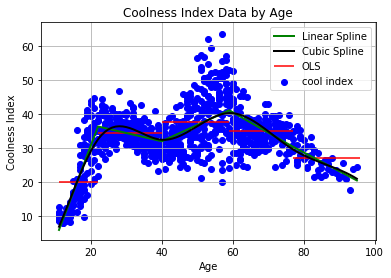

In [11]:
LSQ3 = LSQUnivariateSpline(X,y,t=[22,40,59,77],k=3)
fig,ax = plt.subplots()
ax.hlines(Coef,Up,Down,color='r',label = 'OLS')
ax.plot(Cool['age'],LSQ(Cool['age']),color='g',label = 'Linear Spline',lw=2)
ax.plot(Cool['age'],LSQ3(Cool['age']),color='black',label = 'Cubic Spline',lw=2)
ax.scatter(Cool['age'],Cool['cool index'],color = 'b')
ax.set_xlabel('Age')
ax.set_ylabel('Coolness Index')
ax.set_title('Coolness Index Data by Age')
ax.grid()
ax.legend()
plt.show()

In [12]:
print('The predicted (stepwise function) coolness index for 73-year-old person is %0.3f' \
      %(LSQ3(73)))

The predicted (stepwise function) coolness index for 73-year-old person is 32.642
